# Feature Engineering 

In [1]:
%reset -f
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

import re, sqlite3, pickle, time, datetime, random, sys
# sys.path is a list of absolute path strings
sys.path.append('/home/d/dlr10/Documents/02_Statitics_modelling/0_FunctionsScripts')
import Loading_Data_Functions as load_fn
import FineTuning_Functions as FineTuning
import Learning_Curves_Functions as LearningCurves

pd.options.display.float_format = '{:,.5f}'.format

# 0. Load Data
* https://www.reneshbedre.com/blog/anova.html

In [2]:
t = time.time()
timeSeries      = False
peakstroughs    = False
samp_to_extract = 0
df_patients, df_admissions, df_eobs = load_fn.Load_data('2019_2020')
X_data    = load_fn.Exctract_Xdata(df_patients, df_admissions, df_eobs, samp_to_extract, peakstroughs, timeSeries  )
print("Elapsed time:", time.time()-t)

Elapsed time: 62.9093132019043


In [3]:
X_data.head(4)

,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,...,ALB,ALP,BILI,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,58578756,20.00000,2,110.00000,38.40000,147.00000,92.00000,97.00000,0.00000,0,...,45.00000,137.00000,12.00000,-1,0,59,6,1,1.00000,0
144,31515521,19.00000,3,59.00000,36.80000,113.00000,81.00000,90.00000,0.00000,0,...,41.57143,100.28571,5.85714,-1,0,67,4,1,0.00000,1
288,61428776,28.00000,6,103.00000,37.40000,127.00000,76.00000,97.00000,1.00000,0,...,40.00000,63.00000,9.00000,-1,1,53,0,0,0.00000,1
432,25298427,18.00000,3,88.00000,37.00000,76.00000,54.00000,100.00000,0.00000,0,...,27.00000,110.00000,13.18182,-1,0,64,6,0,1.00000,0


In [4]:
feat_list = X_data.columns.tolist()
feat_list = feat_list[1:-1]
print(feat_list)
print("Number of features:",len(feat_list))

['rr', 'ews', 'heart_rate', 'temperature', 'sbp', 'dbp', 'Oxygen_Saturation', 'Assisted_O2', 'Confusion', 'CREA', 'UREA', 'K', 'GFR', 'WBC', 'PLT', 'HCT', 'HGB', 'RBC', 'MCH', 'MCV', 'NEUAB', 'TLYMAB', 'EOSAB', 'MONAB', 'BASAB', 'ALB', 'ALP', 'BILI', 'sex', 'ethnicity', 'age_at_admin', 'Comorb_score', 'Spcfc_Comorb', 'had_Prev_admin']
Number of features: 34


In [5]:
# Loading the CSV with types
data_types = pd.read_csv('csv_Type_variables.csv')
# Dictionary of features and types
data_types = data_types.set_index('Variable').to_dict()['Type']

# 1. Multicollinearity
* [Link to the example code](https://towardsdatascience.com/multi-collinearity-in-regression-fe7a2c1467ea)
* [Link to Multi-Collinearity: brief description](https://www.britannica.com/topic/collinearity-statistics)
* [Link to Multicollinearity analysis](https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/)
* [Link to Multicollinearity and LogReg, SVM, and random Forest](https://medium.com/@raj5287/effects-of-multi-collinearity-in-logistic-regression-svm-rf-af6766d91f1b)

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [7]:
def calc_variance_inflation_factor(X_in,feat_list):
    # VIF dataframe
    X = X_in[feat_list]
    vif_data = pd.DataFrame()
    vif_data["feature"] = feat_list

    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                              for i in range(len(X.columns))]
    print("VARIANCE INFLATION FACTOR TO ASSES MULTICOLLINEARITY")
    display(vif_data.sort_values(by='VIF', ascending=False))
    return (vif_data)

In [8]:
# Measuring multicollinearity using 
# the independent variables set
sel_feat_list = feat_list.copy()
vif_data = calc_variance_inflation_factor(X_data, sel_feat_list)
######
# Removing features with high collinearity to assess its impact
######
sel_feat_list.remove('temperature')
sel_feat_list.remove('Oxygen_Saturation')
sel_feat_list.remove('ews')
sel_feat_list.remove('rr')
sel_feat_list.remove('age_at_admin')
vif_data = calc_variance_inflation_factor(X_data, sel_feat_list)


VARIANCE INFLATION FACTOR TO ASSES MULTICOLLINEARITY


,feature,VIF
19,MCV,"7,895.20026"
15,HCT,"7,678.08011"
18,MCH,"5,926.31683"
16,HGB,"5,630.42843"
17,RBC,"1,846.47408"
3,temperature,"1,586.11079"
6,Oxygen_Saturation,"1,060.53004"
25,ALB,83.28392
12,GFR,66.26055
4,sbp,54.67880


VARIANCE INFLATION FACTOR TO ASSES MULTICOLLINEARITY


,feature,VIF
15,MCV,"6,105.66029"
14,MCH,"5,898.10027"
11,HCT,"5,725.40723"
12,HGB,"5,563.19217"
13,RBC,454.28795
21,ALB,81.13301
8,GFR,58.61787
7,K,52.58974
1,sbp,48.21214
2,dbp,41.37142


Sholud we normalised encoded data?

[Normalised Encoding Data](https://datascience.stackexchange.com/questions/56142/how-can-i-use-mean-normalization-should-i-use-it-for-numerical-columns-or-categ)

[Encoding Data](https://towardsdatascience.com/categorical-feature-encoding-547707acf4e5#b398)


In [9]:
# Normalise Data
X_data_feat = X_data[feat_list]
X_data_norm = (X_data_feat-X_data_feat.mean())/X_data_feat.std()
X_data_norm.head(4)

,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,CREA,...,BASAB,ALB,ALP,BILI,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
0,-0.30615,-0.65752,1.03766,1.51753,0.86227,1.18241,0.39546,-0.88122,-0.29563,-0.15480,...,1.29599,1.04153,1.18434,-0.06752,-0.90504,-0.42604,-0.74968,0.11231,1.05260,0.96783
144,-0.50949,-0.30330,-1.54019,-0.29520,-0.65665,0.43575,-1.79168,-0.88122,-0.29563,-0.75194,...,-0.03040,0.35715,0.17070,-0.84314,-0.90504,-0.42604,-0.25997,-0.17161,1.05260,-1.03308
288,1.32053,0.75938,0.68383,0.38458,-0.03121,0.09636,0.39546,1.13462,-0.29563,-0.54207,...,-0.57301,0.04348,-0.85872,-0.44631,-0.90504,-0.01942,-1.11696,-0.73945,-0.94988,-1.03308
432,-0.71282,-0.30330,-0.07436,-0.06861,-2.30958,-1.39695,1.33280,-0.88122,-0.29563,-1.28935,...,-0.81417,-2.55146,0.43890,0.08170,-0.90504,-0.42604,-0.44361,0.11231,-0.94988,0.96783


In [10]:
############################################################
# ENCODING CATEGORICAL VARIABLES WITH TARGET ENCODER
# https://towardsdatascience.com/target-encoding-and-bayesian-target-encoding-5c6a6c58ae8c
############################################################
def target_encoder_Binary(column, target, X_data):
    df = []
    for cat in X_data[column].unique():
        row = []
        row.append(len(X_data[(X_data[target]==0) & (X_data[column] == cat)]))
        row.append(len(X_data[(X_data[target]==1) & (X_data[column] == cat)]))
        df.append(row)
    df = pd.DataFrame(df, index = X_data[column].unique(), columns = ['0','1'])
    df['prob'] = df['1']/(df['1']+df['0'])
    col_encod = X_data[column].map(dict(zip(df.index, df['prob'])))
    return col_encod
############################################################
X_data_norm_2 = pd.DataFrame()
for feat in feat_list:
    if data_types[feat] == 'Continuous':
        X_data_feat = X_data[feat]
        X_data_norm_2[feat] = (X_data_feat-X_data_feat.mean())/X_data_feat.std()
    elif data_types[feat] == 'Categorical':
        X_data_norm_2[feat] = target_encoder_Binary(feat, 'Mortality', X_data)
    elif data_types[feat] == 'Binary':
        X_data_norm_2[feat] = X_data[feat].copy()
        
X_data_norm = X_data_norm_2.copy()
X_data_norm.head(4)


,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,CREA,...,BASAB,ALB,ALP,BILI,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
0,-0.30615,0.24308,1.03766,1.51753,0.86227,1.18241,0.39546,0.00000,0,-0.15480,...,1.29599,1.04153,1.18434,-0.06752,-1,0.23369,-0.74968,0.11231,1,1.00000
144,-0.50949,0.21171,-1.54019,-0.29520,-0.65665,0.43575,-1.79168,0.00000,0,-0.75194,...,-0.03040,0.35715,0.17070,-0.84314,-1,0.23369,-0.25997,-0.17161,1,0.00000
288,1.32053,0.21131,0.68383,0.38458,-0.03121,0.09636,0.39546,1.00000,0,-0.54207,...,-0.57301,0.04348,-0.85872,-0.44631,-1,0.22922,-1.11696,-0.73945,0,0.00000
432,-0.71282,0.21171,-0.07436,-0.06861,-2.30958,-1.39695,1.33280,0.00000,0,-1.28935,...,-0.81417,-2.55146,0.43890,0.08170,-1,0.23369,-0.44361,0.11231,0,1.00000


In [11]:
#####################################
# Measuring multicollinearity using 
# the independent variables set
sel_feat_list = feat_list.copy()
vif_data      = calc_variance_inflation_factor(X_data_norm, sel_feat_list)

VARIANCE INFLATION FACTOR TO ASSES MULTICOLLINEARITY


,feature,VIF
15,HCT,224.69410
16,HGB,148.24697
17,RBC,82.63359
19,MCV,61.86033
18,MCH,47.51007
1,ews,41.30236
29,ethnicity,40.73895
9,CREA,7.28838
12,GFR,6.83661
13,WBC,3.17097


# 2. Feature correlation

* Two continuos variables spearman coefficient [-1,1]
* Two Categorical variables Cramer'sV coeeficient [0,1]
* A categorical variable witha  contionuous variables Point biseral correlation [-1,1]

In [12]:
from scipy import stats

In [13]:
########################################################################
# FUNCTION TO DETERMINE THE CORRELATION DEPENDING ON TYPE OF VARIABLES
########################################################################
def correlation_dependednt_type(X_data, feat1, type1, feat2, type2):
    serie1 = X_data[feat1].tolist()
    serie2 = X_data[feat2].tolist()
    type1 = type1 if (type1 == 'Continuous' or type1 == 'Categorical') else 'Categorical'
    type2 = type2 if (type2 == 'Continuous' or type2 == 'Categorical') else 'Categorical'    
    # Spearman correlation for two continuous variables
    if (type1 == 'Continuous') and (type2 == 'Continuous'):
        coef, p = stats.spearmanr(serie1, serie2)
    # Cramer'sV correlation for two categorical variables
    elif (type1 == 'Categorical') and (type2 == 'Categorical'):
        #data = np.array([serie1, serie2])
        df   = pd.DataFrame(zip(serie1, serie2))
        data = np.array(pd.crosstab(df[0],df[1]))
        #Chi-squared test statistic, sample size, and minimum of rows and columns
        X2, p,_,_ = stats.chi2_contingency(data, correction=False)
        n = np.sum(data)
        minDim = min(data.shape)-1
        #calculate Cramer's V 
        coef = np.sqrt((X2/n) / minDim)
    else: # When types are different, Point biserial Correlation
        coef, p = stats.pointbiserialr(np.array(serie1), np.array(serie2))
    return coef, p

In [14]:
########################################################################
# FIND CORRELATION MATRIX
########################################################################
corr = pd.DataFrame(np.zeros((len(feat_list),len(feat_list))), columns = feat_list, index= feat_list)
for idx, feat1 in enumerate(feat_list):
    for feat2 in feat_list[idx:]:
        type1   = data_types[feat1]
        type2   = data_types[feat2]
        if feat1 == feat2:
            corr_ = 1
            p = 0
        else:    
            corr_, p = correlation_dependednt_type(X_data_norm, feat1, type1, feat2, type2)
        corr.at[feat1, feat2] = corr_
        corr.at[feat2, feat1] = corr_
        print(feat1, feat2, p)

rr rr 0
rr ews 9.201146977330495e-79
rr heart_rate 1.4001345880110244e-125
rr temperature 1.0249681156799842e-106
rr sbp 0.25621823739207245
rr dbp 4.73466933984829e-06
rr Oxygen_Saturation 6.87022574044532e-38
rr Assisted_O2 1.4798735706557454e-139
rr Confusion 0.0037990376096866383
rr CREA 0.48667510202552355
rr UREA 0.4225654873083473
rr K 2.710735298503483e-05
rr GFR 0.3665253415805564
rr WBC 0.17950256654139773
rr PLT 0.11484104614115108
rr HCT 1.9567867129416788e-27
rr HGB 1.0768785213678451e-26
rr RBC 1.197024047124787e-38
rr MCH 4.0699580745583245e-06
rr MCV 1.2589066296219914e-07
rr NEUAB 0.002034976930196373
rr TLYMAB 2.913276642259456e-24
rr EOSAB 2.727783762135051e-39
rr MONAB 3.225499057273408e-11
rr BASAB 0.30560225408015246
rr ALB 9.219100135456905e-17
rr ALP 0.0005730347797834954
rr BILI 0.19656030505985553
rr sex 0.0015622447691469787
rr ethnicity 4.215186045694996e-12
rr age_at_admin 4.278290795615041e-09
rr Comorb_score 0.00802430625987003
rr Spcfc_Comorb 0.107763704

Confusion ethnicity 0.8240030978803
Confusion age_at_admin 2.285733304373885e-09
Confusion Comorb_score 0.00017155345181883415
Confusion Spcfc_Comorb 0.0005398130671961419
Confusion had_Prev_admin 0.023134669034762835
CREA CREA 0
CREA UREA 0.0
CREA K 4.637242186730494e-101
CREA GFR 0.0
CREA WBC 6.914880027395794e-13
CREA PLT 4.198781496647957e-28
CREA HCT 9.061630391490146e-17
CREA HGB 6.824477694946922e-25
CREA RBC 1.4206805940888714e-25
CREA MCH 0.7125963678111252
CREA MCV 8.866599314138489e-10
CREA NEUAB 1.440658990042929e-14
CREA TLYMAB 4.847917137672329e-05
CREA EOSAB 0.0022044537413739122
CREA MONAB 2.8590695891020195e-10
CREA BASAB 0.12274565816004682
CREA ALB 0.0002481358816496705
CREA ALP 0.0055253769225992915
CREA BILI 0.10289200615084412
CREA sex 4.902239135077085e-41
CREA ethnicity 0.00013904643496686307
CREA age_at_admin 4.40947293805499e-114
CREA Comorb_score 1.496084281090347e-199
CREA Spcfc_Comorb 7.243695753057884e-54
CREA had_Prev_admin 3.4768013510513747e-12
UREA URE

sex age_at_admin 2.2279834785976333e-09
sex Comorb_score 0.8522086442561224
sex Spcfc_Comorb 0.214388900364307
sex had_Prev_admin 0.017977480654766047
ethnicity ethnicity 0
ethnicity age_at_admin 4.021100205091536e-77
ethnicity Comorb_score 1.5035858386822778e-07
ethnicity Spcfc_Comorb 4.590467255220966e-12
ethnicity had_Prev_admin 5.681844600359014e-35
age_at_admin age_at_admin 0
age_at_admin Comorb_score 9.916295073302986e-204
age_at_admin Spcfc_Comorb 3.2123866503152233e-78
age_at_admin had_Prev_admin 4.244883110477133e-39
Comorb_score Comorb_score 0
Comorb_score Spcfc_Comorb 5.1326008085814364e-141
Comorb_score had_Prev_admin 1.587648089665065e-58
Spcfc_Comorb Spcfc_Comorb 0
Spcfc_Comorb had_Prev_admin 1.7165479015793073e-52
had_Prev_admin had_Prev_admin 0


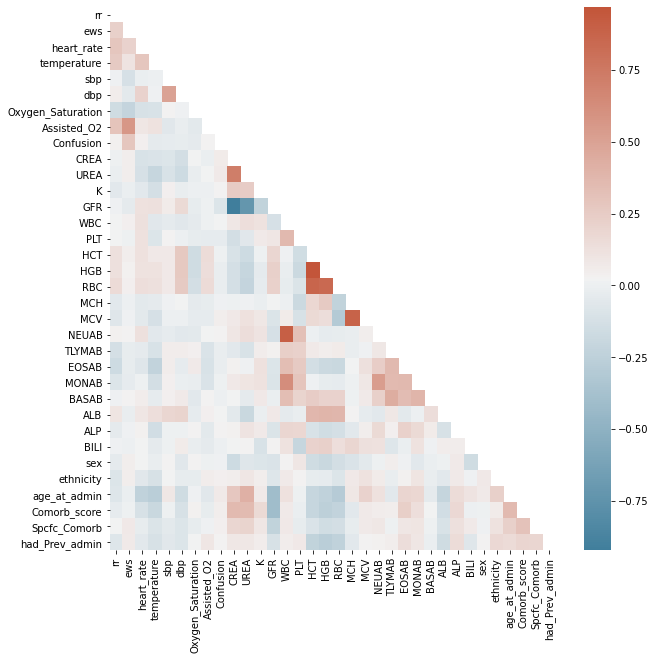

In [15]:
########################################################################
# PLOT CORRELATION MATRIX
########################################################################
f, ax = plt.subplots(figsize=(10, 10))
# Generate a mask for upper traingle#
mask = np.triu(np.ones_like(corr, dtype=bool))
# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap
sns.heatmap(corr,  mask = mask, cmap=cmap)
plt.show()

# 3. Logistic Regression to asses significance

### Data to process

In [16]:
X_data_norm.head(5)
df_results = pd.DataFrame()

### 3.1 Individual variable significance

In [17]:
from scipy import stats

In [18]:
########################################################################
# VARIABLE INDIVIDUAL SIGNIFICANCE
########################################################################
p_norm_test = []
idx_0 = X_data[X_data['Mortality'] == 0].index
idx_1 = X_data[X_data['Mortality'] == 1].index
for idx, feat1 in enumerate(feat_list):
    x_0 = X_data_norm.loc[idx_0][feat1]
    x_1 = X_data_norm.loc[idx_1][feat1]
    type1  = data_types[feat1]
    sts, p = stats.ttest_ind(x_0, x_1)
    p_norm_test.append(p)

In [19]:
########################################################################
# RESULTS
########################################################################
df_results['pval_Indiv'] = p_norm_test
display(df_results)

,pval_Indiv
0,0.49219
1,0.00000
2,0.00121
3,0.00000
4,0.00679
5,0.00633
6,0.02972
7,0.65971
8,0.00278
9,0.00000


### 3.2 Multivariate Logistic Regression

In [20]:
import statsmodels.api as sm

In [21]:
X_train = X_data_norm
y_train = X_data['Mortality']
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.474260
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              Mortality   No. Observations:                 6531
Model:                          Logit   Df Residuals:                     6497
Method:                           MLE   Df Model:                           33
Date:                Sun, 01 May 2022   Pseudo R-squ.:                  0.1156
Time:                        22:39:02   Log-Likelihood:                -3097.4
converged:                       True   LL-Null:                       -3502.4
Covariance Type:            nonrobust   LLR p-value:                6.598e-149
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
rr                    0.0668      0.036      1.874      0.061      -0.003       0.137
ews     

In [22]:
df_results['pval_logR'] = result.pvalues.tolist()

### 3.3 Lasso Regression Original Data

In [23]:
X_data[feat_list].head(3)

,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,CREA,...,BASAB,ALB,ALP,BILI,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
0,20.00000,2,110.00000,38.40000,147.00000,92.00000,97.00000,0.00000,0,95.00000,...,0.08000,45.00000,137.00000,12.00000,-1,0,59,6,1,1.00000
144,19.00000,3,59.00000,36.80000,113.00000,81.00000,90.00000,0.00000,0,65.14286,...,0.04000,41.57143,100.28571,5.85714,-1,0,67,4,1,0.00000
288,28.00000,6,103.00000,37.40000,127.00000,76.00000,97.00000,1.00000,0,75.63636,...,0.02364,40.00000,63.00000,9.00000,-1,1,53,0,0,0.00000


In [24]:
import regressors
from sklearn.linear_model import LassoCV
from regressors import stats

In [25]:
X_train = X_data[feat_list]
y_train = X_data['Mortality']

In [26]:
lasso_reg = LassoCV(cv = 5)
lasso_reg.fit(X_train, y_train)

regressors.stats.summary(lasso_reg, X_train, y_train)

Residuals:
     Min      1Q  Median      3Q     Max
-0.30240 0.13710 0.22970 0.32250 0.69150


Coefficients:
            Estimate  Std. Error  t value  p value
_intercept   0.81082     0.39951  2.02950  0.04244
x1           0.00142     0.00121  1.16810  0.24282
x2           0.00256     0.00303  0.84310  0.39923
x3           0.00036     0.00026  1.38460  0.16623
x4          -0.01513     0.00421 -3.59280  0.00033
x5          -0.00068     0.00023 -2.93300  0.00337
x6           0.00076     0.00040  1.93260  0.05333
x7          -0.00122     0.00106 -1.14790  0.25104
x8          -0.00000     0.01263 -0.00000  1.00000
x9           0.00000     0.01957  0.00000  1.00000
x10         -0.00057     0.00014 -4.06290  0.00005
x11          0.01069     0.00153  7.01040  0.00000
x12         -0.00182     0.00820 -0.22240  0.82404
x13         -0.00067     0.00043 -1.54570  0.12224
x14         -0.00742     0.00139 -5.35110  0.00000
x15         -0.00007     0.00004 -1.64010  0.10103
x16         -0.00000    

In [27]:
p_vals_lasso = list(regressors.stats.coef_pval(lasso_reg, X_train, y_train))[1:]
df_results['pval_Lasso_org'] = p_vals_lasso

### 3.4 Lasso Regression Normalised Data

In [28]:
X_train = X_data[feat_list]
y_train = X_data['Mortality']

In [29]:
lasso_reg_norm = LassoCV(cv = 5)
lasso_reg_norm.fit(X_train, y_train)

regressors.stats.summary(lasso_reg_norm, X_train, y_train)

Residuals:
     Min      1Q  Median      3Q     Max
-0.30240 0.13710 0.22970 0.32250 0.69150


Coefficients:
            Estimate  Std. Error  t value  p value
_intercept   0.81082     0.39951  2.02950  0.04244
x1           0.00142     0.00121  1.16810  0.24282
x2           0.00256     0.00303  0.84310  0.39923
x3           0.00036     0.00026  1.38460  0.16623
x4          -0.01513     0.00421 -3.59280  0.00033
x5          -0.00068     0.00023 -2.93300  0.00337
x6           0.00076     0.00040  1.93260  0.05333
x7          -0.00122     0.00106 -1.14790  0.25104
x8          -0.00000     0.01263 -0.00000  1.00000
x9           0.00000     0.01957  0.00000  1.00000
x10         -0.00057     0.00014 -4.06290  0.00005
x11          0.01069     0.00153  7.01040  0.00000
x12         -0.00182     0.00820 -0.22240  0.82404
x13         -0.00067     0.00043 -1.54570  0.12224
x14         -0.00742     0.00139 -5.35110  0.00000
x15         -0.00007     0.00004 -1.64010  0.10103
x16         -0.00000    

In [30]:
p_vals_lasso_norm = list(regressors.stats.coef_pval(lasso_reg_norm, X_train, y_train))[1:]
df_results['pval_Lasso_norm'] = p_vals_lasso_norm

### 3.5 Ridge Linear Regression

In [31]:
from sklearn.linear_model import RidgeCV
from regressors import stats

In [32]:
X_train = X_data_norm
y_train = X_data['Mortality']

In [33]:
rr_scaled = RidgeCV(cv =5)
rr_scaled.fit(X_train, y_train)

regressors.stats.summary(rr_scaled, X_train, y_train)

Residuals:
     Min      1Q  Median      3Q     Max
-0.34570 0.13150 0.22860 0.32350 0.99110


Coefficients:
            Estimate  Std. Error  t value  p value
_intercept   0.00682     0.02590  0.26330  0.79234
x1           0.00871     0.00532  1.63730  0.10161
x2           0.80733     0.17847  4.52350  0.00001
x3           0.00550     0.00547  1.00640  0.31427
x4          -0.01883     0.00542 -3.47450  0.00052
x5          -0.01237     0.00568 -2.17830  0.02942
x6           0.01108     0.00584  1.89820  0.05772
x7          -0.00258     0.00501 -0.51500  0.60659
x8          -0.00747     0.01016 -0.73510  0.46229
x9          -0.00402     0.01814 -0.22150  0.82468
x10         -0.03443     0.01125 -3.05890  0.00223
x11          0.05318     0.00752  7.07430  0.00000
x12         -0.00766     0.00518 -1.47780  0.13951
x13         -0.02159     0.01095 -1.97190  0.04866
x14         -0.04094     0.00789 -5.18780  0.00000
x15         -0.00671     0.00565 -1.18770  0.23501
x16         -0.04053    

In [34]:
p_vals_ridge = list(regressors.stats.coef_pval(rr_scaled, X_train, y_train))[1:]
df_results['pval_Ridge'] = p_vals_ridge

In [35]:
###########################################
# DISPLAY RESULTS
###########################################
display(df_results)

,pval_Indiv,pval_logR,pval_Lasso_org,pval_Lasso_norm,pval_Ridge
0,0.49219,0.06093,0.24282,0.24282,0.10161
1,0.00000,0.85179,0.39923,0.39923,0.00001
2,0.00121,0.18406,0.16623,0.16623,0.31427
3,0.00000,0.00100,0.00033,0.00033,0.00052
4,0.00679,0.04132,0.00337,0.00337,0.02942
5,0.00633,0.11350,0.05333,0.05333,0.05772
6,0.02972,0.05406,0.25104,0.25104,0.60659
7,0.65971,0.75991,1.00000,1.00000,0.46229
8,0.00278,0.76862,1.00000,1.00000,0.82468
9,0.00000,0.01737,0.00005,0.00005,0.00223


# _______________________________________

# 4. Feature Importance

#### Using Random Forrest, Decision Trees and XGBoost models
[Explanation of importance calculus](https://towardsdatascience.com/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3)

In [36]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import svm

In [37]:
X_train = X_data_norm
y_train = X_data['Mortality']

In [38]:
row = []

y = np.array(X_data['Mortality'])
#X = np.array(X_data_norm)
X = X_data[feat_list]
#model = DecisionTreeRegressor()
#model = RandomForestRegressor()

# fit the model DTree
model_DTree  = DecisionTreeRegressor()
model_DTree.fit(X, y)
import_DTree = model_DTree.feature_importances_

# fit the model RFor
model_RFor  = RandomForestRegressor()
model_RFor.fit(X, y)
import_RFor = model_RFor.feature_importances_

# fit the model XGB
model_XGB  =  XGBRegressor()
model_XGB.fit(X, y)
import_XGB = model_XGB.feature_importances_

for i,v in enumerate(import_DTree):
    row.append((v, import_RFor[i], import_XGB[i]))
row = pd.DataFrame(row, columns = ['import_DT', 'import_RF', 'import_XGB'], index = feat_list)
display(row)

,import_DT,import_RF,import_XGB
rr,0.02475,0.02216,0.00907
ews,0.01898,0.01655,0.01417
heart_rate,0.03305,0.03279,0.01811
temperature,0.01904,0.03156,0.02322
sbp,0.04321,0.03212,0.02387
dbp,0.03531,0.03405,0.02555
Oxygen_Saturation,0.03104,0.02021,0.02311
Assisted_O2,0.00187,0.00323,0.01861
Confusion,0.00310,0.00237,0.02470
CREA,0.03858,0.03408,0.02834


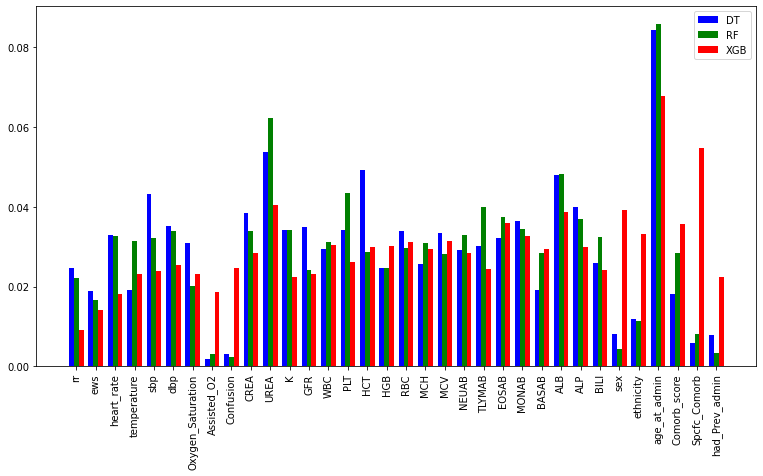

In [39]:

X = np.arange(len(feat_list))

fig = plt.figure(figsize = (10,5))
ax  = fig.add_axes([0,0,1,1])


ax.bar(X - 0.25, row['import_DT'],  color = 'b', width = 0.25, label ='DT')
ax.bar(X + 0.00, row['import_RF'],  color = 'g', width = 0.25, label='RF')
ax.bar(X + 0.25, row['import_XGB'], color = 'r', width = 0.25, label = 'XGB')

ax.set_xticks(np.arange(len(feat_list)))
ax.set_xticklabels(feat_list, rotation = 90)
ax.legend()
plt.savefig('Feature_selection_19_20.png', transparent = True, bbox_inches = "tight")
plt.show()

# Description of Variables

In [40]:
import math 
print('Continuous variables')
df_descrip    = []
idx_cont_cols = [i for i, name in enumerate(feat_list) if data_types[name] == 'Continuous']
X = np.asarray(X_data[X_data['Mortality']==0][feat_list])

for idx in idx_cont_cols:
    m      = X[:, idx].mean()
    s      = X[:, idx].std()
    ci95   = ['{:.2f}'.format(m - 1.95*s/math.sqrt(len(X))),'{:.2f}'.format(m + 1.95*s/math.sqrt(len(X)))]
    mm_rng = ['{:.2f}'.format(X[:, idx].min()), '{:.2f}'.format(X[:,idx].max())]
    row    = [feat_list[idx]] + ['{:.2f}'.format(m), '{:.2f}'.format(s), '{:.2f}'.format(np.median(X[:, idx]))
                                  , ci95, mm_rng]
    df_descrip.append(row)  
    
df_descrip_0 = pd.DataFrame (df_descrip, columns = ['variable','mean', 'st_dev', 'median', 'conf-int', 'Min-Max rng'])
display(df_descrip_0)

#___________________________________________________________________________________________________
#___________________________________________________________________________________________________
df_descrip    = []
X = np.asarray(X_data[X_data['Mortality']==1][feat_list])

for idx in idx_cont_cols:
    m      = X[:, idx].mean()
    s      = X[:, idx].std()
    ci95   = ['{:.2f}'.format(m - 1.95*s/math.sqrt(len(X))),'{:.2f}'.format(m + 1.95*s/math.sqrt(len(X)))]
    mm_rng = ['{:.2f}'.format(X[:, idx].min()), '{:.2f}'.format(X[:,idx].max())]
    row    = [feat_list[idx]] + ['{:.2f}'.format(m), '{:.2f}'.format(s), '{:.2f}'.format(np.median(X[:, idx]))
                                  , ci95, mm_rng]
    df_descrip.append(row)  
    
df_descrip_1 = pd.DataFrame (df_descrip, columns = ['variable','mean', 'st_dev', 'median', 'conf-int', 'Min-Max rng'])
display(df_descrip_1)

Continuous variables


,variable,mean,st_dev,median,conf-int,Min-Max rng
0,rr,21.48,4.89,20.00,"[21.35, 21.62]","[9.00, 40.00]"
1,heart_rate,89.90,19.50,89.00,"[89.37, 90.44]","[27.00, 160.00]"
2,temperature,37.12,0.88,37.00,"[37.09, 37.14]","[30.40, 41.50]"
3,sbp,128.11,22.18,126.00,"[127.50, 128.71]","[64.00, 200.00]"
4,dbp,74.85,14.44,74.00,"[74.45, 75.25]","[40.00, 120.00]"
5,Oxygen_Saturation,95.78,3.09,96.00,"[95.70, 95.87]","[61.00, 100.00]"
6,CREA,98.90,47.59,86.00,"[97.59, 100.21]","[21.00, 328.00]"
7,UREA,7.98,4.82,6.66,"[7.85, 8.12]","[1.40, 29.44]"
8,K,4.25,0.63,4.20,"[4.23, 4.26]","[2.20, 7.00]"
9,GFR,67.89,21.34,72.67,"[67.30, 68.47]","[20.00, 90.00]"


,variable,mean,st_dev,median,conf-int,Min-Max rng
0,rr,21.58,5.02,20.00,"[21.33, 21.84]","[11.00, 40.00]"
1,heart_rate,88.01,20.66,87.00,"[86.97, 89.06]","[24.00, 160.00]"
2,temperature,36.87,0.86,36.80,"[36.82, 36.91]","[30.60, 40.80]"
3,sbp,126.32,22.99,125.00,"[125.15, 127.48]","[64.00, 199.00]"
4,dbp,73.66,15.65,72.00,"[72.87, 74.46]","[40.00, 119.00]"
5,Oxygen_Saturation,95.58,3.53,96.00,"[95.40, 95.75]","[63.00, 100.00]"
6,CREA,115.78,55.46,101.86,"[112.97, 118.58]","[24.00, 325.00]"
7,UREA,10.61,5.91,9.02,"[10.32, 10.91]","[1.62, 30.00]"
8,K,4.31,0.68,4.27,"[4.28, 4.35]","[2.30, 7.00]"
9,GFR,59.04,22.27,58.45,"[57.91, 60.17]","[20.00, 90.00]"


In [41]:
import math 
print('Binary variables')
df_descrip    = []
idx_cont_cols = [i for i, name in enumerate(feat_list) if data_types[name] == 'Binary']
#X = np.asarray(X_data[X_data['Mortality']==0][feat_list])
X = X_data[X_data['Mortality']==0][feat_list]

for idx in idx_cont_cols:
    name    = feat_list[idx]
    count_1 = len(X[X[name]==1])
    percent = 100* count_1/len(X[name])
    row = [feat_list[idx], count_1, '{:.2f}'.format( percent)]
    df_descrip.append(row)  
    
df_descrip = pd.DataFrame (df_descrip, columns = ['variable','count', 'percent'])
display(df_descrip)

#___________________________________________________________________________________________________
#___________________________________________________________________________________________________


df_descrip_1   = []
#X = np.asarray(X_data[X_data['Mortality']==0][feat_list])
X = X_data[X_data['Mortality']==1][feat_list]

for idx in idx_cont_cols:
    name    = feat_list[idx]
    count_1 = len(X[X[name]==1])
    percent = 100* count_1/len(X[name])
    row = [feat_list[idx], count_1, '{:.2f}'.format( percent)]
    df_descrip_1.append(row)  
    
df_descrip_1 = pd.DataFrame (df_descrip_1, columns = ['variable','count', 'percent'])
display(df_descrip_1)

Binary variables


,variable,count,percent
0,Assisted_O2,2198,43.57
1,Confusion,378,7.49
2,sex,2326,46.11
3,Spcfc_Comorb,2185,43.31
4,had_Prev_admin,2501,49.57


,variable,count,percent
0,Assisted_O2,657,44.21
1,Confusion,147,9.89
2,sex,615,41.39
3,Spcfc_Comorb,913,61.44
4,had_Prev_admin,871,58.61


In [42]:
import math 
print('Categorical variables')
df_descrip    = []
idx_cont_cols = [i for i, name in enumerate(feat_list) if data_types[name] == 'Categorical']
#X = np.asarray(X_data[X_data['Mortality']==0][feat_list])
X = np.asarray(X_data[X_data['Mortality']==0][feat_list])

for idx in idx_cont_cols:
    name    = feat_list[idx]
    median  = np.median(X[:, idx])
    iqr     = np.percentile(X[:, idx], [75 ,25])
    row = [feat_list[idx], median, iqr]
    df_descrip.append(row)  
    
df_descrip = pd.DataFrame (df_descrip, columns = ['variable','median', 'iqr'])
display(df_descrip)

#___________________________________________________________________________________________________
#___________________________________________________________________________________________________


df_descrip_1   = []
#X = np.asarray(X_data[X_data['Mortality']==0][feat_list])
X = np.asarray(X_data[X_data['Mortality']==1][feat_list])

for idx in idx_cont_cols:
    name    = feat_list[idx]
    median  = np.median(X[:, idx])
    iqr     = np.percentile(X[:, idx], [75 ,25])
    row = [feat_list[idx], median, iqr]
    df_descrip_1.append(row)  
    
df_descrip_1 = pd.DataFrame (df_descrip_1, columns = ['variable','median', 'iqr'])
display(df_descrip_1)

Categorical variables


,variable,median,iqr
0,ews,4.00000,"[6.0, 2.0]"
1,ethnicity,0.00000,"[1.0, 0.0]"


,variable,median,iqr
0,ews,4.00000,"[6.0, 2.0]"
1,ethnicity,0.00000,"[1.0, 0.0]"


In [43]:
print(len(X_data[X_data['Mortality']==0][feat_list]))
print(len(X_data[X_data['Mortality']==1][feat_list]))

5045
1486


In [44]:
X_data

,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,...,ALB,ALP,BILI,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,58578756,20.00000,2,110.00000,38.40000,147.00000,92.00000,97.00000,0.00000,0,...,45.00000,137.00000,12.00000,-1,0,59,6,1,1.00000,0
144,31515521,19.00000,3,59.00000,36.80000,113.00000,81.00000,90.00000,0.00000,0,...,41.57143,100.28571,5.85714,-1,0,67,4,1,0.00000,1
288,61428776,28.00000,6,103.00000,37.40000,127.00000,76.00000,97.00000,1.00000,0,...,40.00000,63.00000,9.00000,-1,1,53,0,0,0.00000,1
432,25298427,18.00000,3,88.00000,37.00000,76.00000,54.00000,100.00000,0.00000,0,...,27.00000,110.00000,13.18182,-1,0,64,6,0,1.00000,0
576,34942369,18.00000,0,66.00000,37.00000,115.00000,75.00000,98.00000,0.00000,0,...,28.00000,54.00000,16.00000,-1,9,65,0,1,1.00000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939744,92754686,14.00000,5,108.00000,37.00000,96.00000,69.00000,100.00000,1.00000,0,...,43.00000,192.00000,9.00000,1,0,60,2,1,1.00000,1
939888,20387671,28.00000,11,132.00000,39.40000,104.00000,72.00000,92.00000,0.00000,0,...,41.00000,91.40000,9.80000,1,0,49,0,0,0.00000,0
940032,65936165,33.00000,8,76.00000,37.60000,146.00000,78.00000,90.00000,1.00000,0,...,36.56250,70.00000,18.00000,-1,4,65,0,0,0.00000,0
940176,40846799,16.00000,1,48.00000,36.35000,145.00000,45.00000,96.00000,0.00000,0,...,38.00000,62.00000,3.00000,1,0,81,1,0,1.00000,0


In [49]:
admins_data   = X_data['admission_id'].unique().tolist()
patients_data = df_admissions[df_admissions['admission_id'].isin(admins_data)]['patient_id'].unique().tolist()
print(len(admins_data))
print(len(patients_data))
#patients_data = df_admissions[]


6531
6050


In [53]:
df_admissions[df_admissions['admission_id'].isin(admins_data)].groupby(by=['patient_id']).count().sort_values(by=['admission_id'])

,admission_id,episode_diagnoses,age_at_admission\r,admission_date_time,admission_date_code_time,discharge_date_time,discharge_date_code_time,lengthofstay,isPneumonia,mortal_admin,icu_count\r,Comorbidity_score,no_obs_eobs,no_haematology_eobs,receivedMedicines,Specific Comorbidity,had_Prev_admin,adm_has_spin,CURB65,antibiotic_4h
patient_id,,,,,,,,,,,,,,,,,,,,
25667,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0
66034758,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0
65946856,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0
65930677,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0
65928293,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67729596,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,2,2,2
77672627,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,0,0,0
86796473,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,0,0,0


In [45]:
########################################################################
# KOLMOGOROV-SMIRNOV TEST OF NORMALITY
########################################################################
from scipy import stats
df_norm_test = []
for idx, feat1 in enumerate(feat_list):
    x  = X_data_norm[feat1]
    x2 = X_data[feat1]
    cff, p  = stats.kstest(x, 'norm')
    cff, p2 = stats.kstest(x2, 'norm')
    df_norm_test.append([feat1, p, p2])
df_norm_test = pd.DataFrame(df_norm_test, columns = ['feature', 'p_norm','p_raw'])
display(df_norm_test)

,feature,p_norm,p_raw
0,rr,0.00000,0.00000
1,ews,0.00000,0.00000
2,heart_rate,0.00000,0.00000
3,temperature,0.00000,0.00000
4,sbp,0.00000,0.00000
5,dbp,0.00000,0.00000
6,Oxygen_Saturation,0.00000,0.00000
7,Assisted_O2,0.00000,0.00000
8,Confusion,0.00000,0.00000
9,CREA,0.00000,0.00000
